In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

In [42]:
# Importing and Preparing Dataset
print("Importing and Preparing Dataset...")

data_path = "../data/secondary_data.csv"
df = pd.read_csv(data_path, sep=";")

target_col = "class"
X = df.drop(columns=[target_col])
y = df[target_col].map({'p': 1, 'e': 0}) 

categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

print(f"Total Feature Count: {X.shape[1]}")

Importing and Preparing Dataset...
Total Feature Count: 20


In [43]:
# Pipeline
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing_value")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [44]:
# Train and Test Data Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [45]:
# Dummy Model
print("\nTraining Baseline (Dummy) Model...")

dummy_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DummyClassifier(strategy="most_frequent"))
])
dummy_pipeline.fit(X_train, y_train)
y_pred_dummy = dummy_pipeline.predict(X_test)
y_proba_dummy = dummy_pipeline.predict_proba(X_test)[:, 1]

dummy_acc = accuracy_score(y_test, y_pred_dummy)
dummy_f1 = f1_score(y_test,y_pred_dummy)
dummy_prec = precision_score(y_test, y_pred_dummy, zero_division=0)
dummy_rec = recall_score(y_test, y_pred_dummy)

print(f"-> Dummy Accuracy: {dummy_acc:.4f}")
print(f"-> Dummy F1: {dummy_f1:.4f}")
print(f"-> Dummy Precision: {dummy_prec:.4f}")
print(f"-> Dummy Recall: {dummy_rec:.4f}")


Training Baseline (Dummy) Model...
-> Dummy Accuracy: 0.5549
-> Dummy F1: 0.7138
-> Dummy Precision: 0.5549
-> Dummy Recall: 1.0000



Confusion Matrix(Dummy Model)...
Image saved to disk.


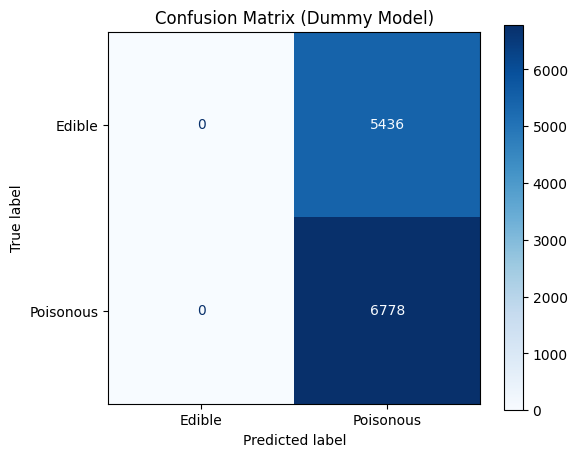

In [46]:
# Graph 1: Confusion Matrix(Dummy Model)
print("\nConfusion Matrix(Dummy Model)...")

fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dummy, ax=ax, cmap='Blues', display_labels=['Edible', 'Poisonous'])
ax.set_title("Confusion Matrix (Dummy Model)")
plt.savefig('confusion_matrix_dummy_final.png')
print("Image saved to disk.")


ROC Curve(Dummy Model)...
Image saved to disk.


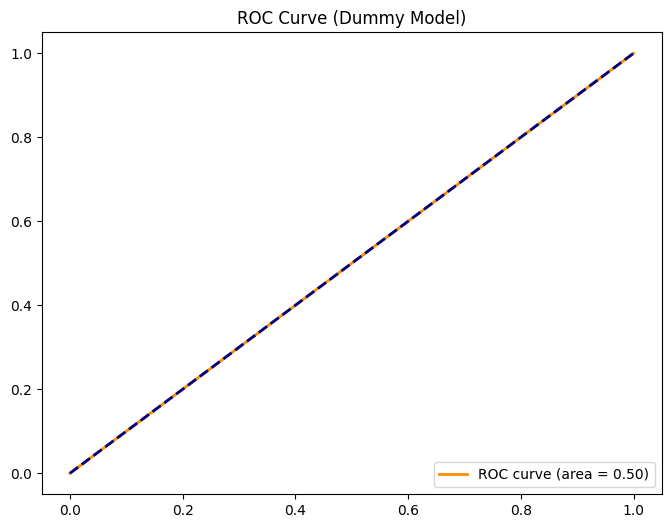

In [47]:
# Graph 2: ROC Curve(Dummy Model)
print("\nROC Curve(Dummy Model)...")

fpr, tpr, thresholds = roc_curve(y_test, y_proba_dummy)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc="lower right")
plt.title('ROC Curve (Dummy Model)')
plt.savefig('roc_curve_dummy_final.png')
print("Image saved to disk.")

In [48]:
# Logistic Regression
print("\nTraining Logistic Regression Model...")

lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])
lr_pipeline.fit(X_train, y_train)
y_pred_lr= lr_pipeline.predict(X_test)
y_proba_lr=lr_pipeline.predict_proba(X_test)[:, 1]

lr_acc = accuracy_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test,y_pred_lr)
lr_prec = precision_score(y_test, y_pred_lr, zero_division=0)
lr_rec = recall_score(y_test, y_pred_lr)

print(f"-> LR Accuracy: {lr_acc:.4f}")
print(f"-> LR F1: {lr_f1:.4f}")
print(f"-> LR Precision: {lr_prec:.4f}")
print(f"-> LR Recall: {lr_rec:.4f}")


Training Logistic Regression Model...
-> LR Accuracy: 0.8683
-> LR F1: 0.8787
-> LR Precision: 0.8982
-> LR Recall: 0.8601



Confusion Matrix(Logistic Regression)...
Image Saved to Disk


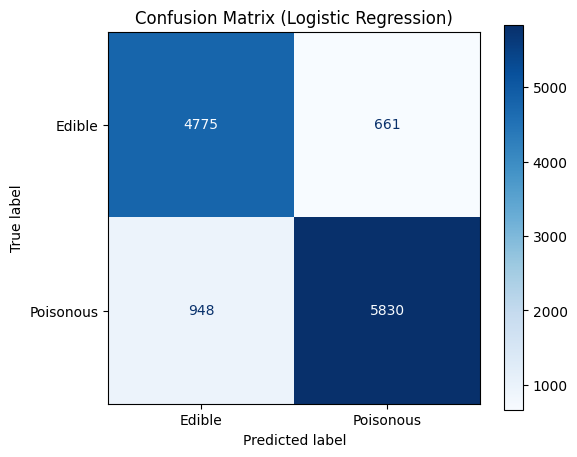

In [49]:
# Graph 3: Confusion Matrix(Logistic Regression)
print("\nConfusion Matrix(Logistic Regression)...")

fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, ax=ax, cmap='Blues', display_labels=['Edible', 'Poisonous'])
ax.set_title("Confusion Matrix (Logistic Regression)")
plt.savefig('confusion_matrix_lr_final.png')
print("Image Saved to Disk")


ROC Curve(Logistic Regression)...
Image Saved to Disk


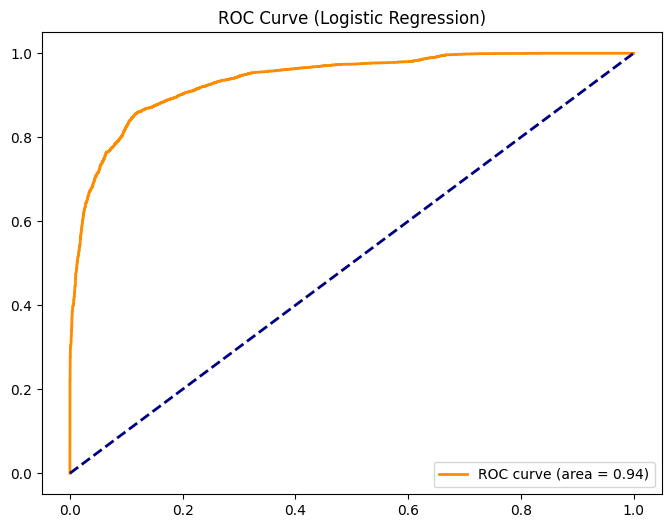

In [50]:
# Graph 4: ROC Curve(Logistic Regression)
print("\nROC Curve(Logistic Regression)...")

fpr, tpr, thresholds = roc_curve(y_test, y_proba_lr)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc="lower right")
plt.title('ROC Curve (Logistic Regression)')
plt.savefig('roc_curve_lr_final.png')
print("Image Saved to Disk")


Feature Importance(Logistic Regression)...
Image Saved to Disk


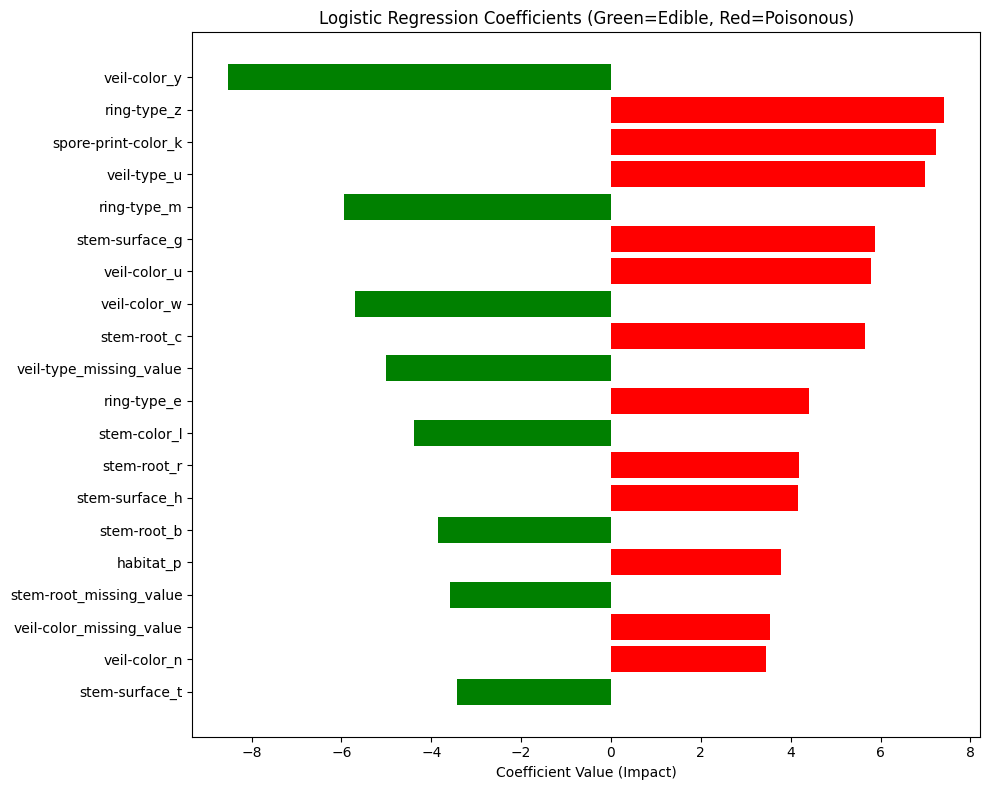

In [51]:
# Graph 5: Feature Importance(Logistic Regression)
print("\nFeature Importance(Logistic Regression)...")

coeffs = lr_pipeline.named_steps['classifier'].coef_[0]
ohe = lr_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_feature_names = ohe.get_feature_names_out(categorical_cols)
all_feature_names = np.r_[numeric_cols, cat_feature_names]

indices = np.argsort(np.abs(coeffs))[-20:]

plt.figure(figsize=(10, 8))
colors = ['red' if coeffs[i] > 0 else 'green' for i in indices]

plt.barh(range(len(indices)), coeffs[indices], color=colors, align="center")
plt.yticks(range(len(indices)), [all_feature_names[i] for i in indices])
plt.title("Logistic Regression Coefficients (Green=Edible, Red=Poisonous)")
plt.xlabel("Coefficient Value (Impact)")
plt.tight_layout()
plt.savefig('feature_importance_lr_final.png')
print("Image Saved to Disk")

In [52]:
# Random Forest (UNTUNED!)
print("\nTraining Random Forest Model(DEFAULT)...")

rf_default_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

rf_default_pipeline.fit(X_train, y_train)
y_pred_rf_def = rf_default_pipeline.predict(X_test)
y_proba_rf_def = rf_default_pipeline.predict_proba(X_test)[:, 1]

rf_def_acc = accuracy_score(y_test, y_pred_rf_def)
rf_def_f1 = f1_score(y_test, y_pred_rf_def)
rf_def_prec = precision_score(y_test, y_pred_rf_def)
rf_def_rec = recall_score(y_test, y_pred_rf_def)

print(f"RF (Default) Accuracy: {rf_def_acc:.4f}")
print(f"RF (Default) F1: {rf_def_f1:.4f}")
print(f"RF (Default) Precision: {rf_def_prec:.4f}")
print(f"RF (Default) Recall: {rf_def_rec:.4f}")


Training Random Forest Model(DEFAULT)...
RF (Default) Accuracy: 1.0000
RF (Default) F1: 1.0000
RF (Default) Precision: 1.0000
RF (Default) Recall: 1.0000



Confusion Matrix(Default Random Forest)...
Image Saved to Disk


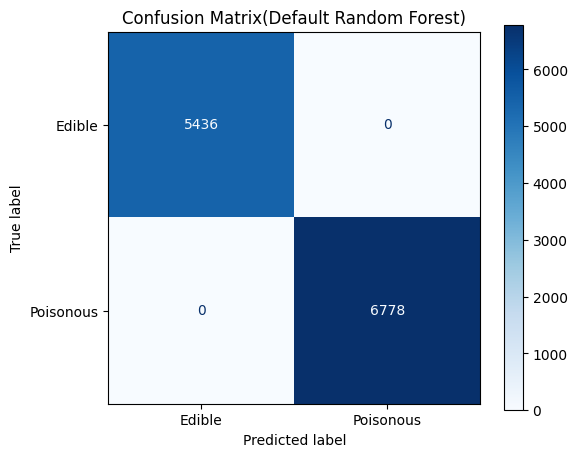

In [53]:
# Graph 6: Confusion Matrix (Default Random Forest)
print("\nConfusion Matrix(Default Random Forest)...")

fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf_def, ax=ax, cmap='Blues', display_labels=['Edible', 'Poisonous'])
ax.set_title("Confusion Matrix(Default Random Forest)")
plt.savefig('confusion_matrix_rf_def_final.png')
print("Image Saved to Disk")


ROC Curve(Default Random Forest)...
Image Saved to Disk


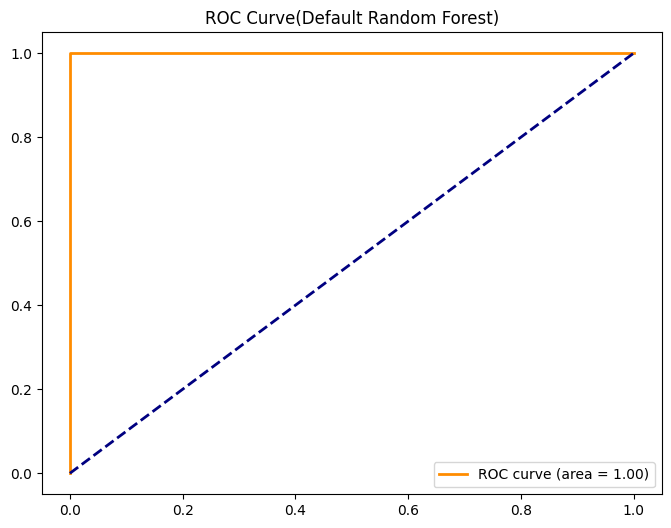

In [54]:
# Graph 7: ROC Curve (Default Random Forest)
print("\nROC Curve(Default Random Forest)...")

fpr, tpr, thresholds = roc_curve(y_test, y_proba_rf_def)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc="lower right")
plt.title('ROC Curve(Default Random Forest)')
plt.savefig('roc_curve_rf_def_final.png')
print("Image Saved to Disk")

In [55]:
# Hyperparameter Tuning (Tuned Random Forest)
print("\nStarted Random Forest Tuning... (With 4 Parameters)")

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

param_grid = {
    'classifier__n_estimators': [50, 100],       # Ağaç sayısı
    'classifier__max_depth': [10, 20, None],     # Maksimum derinlik
    'classifier__min_samples_split': [2, 5],     # Bölünme için min örnek
    'classifier__min_samples_leaf': [1, 2]       # Yaprak için min örnek
}

grid_search = GridSearchCV(rf_pipeline, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"Best Parameters: {best_params}")


Started Random Forest Tuning... (With 4 Parameters)
Fitting 3 folds for each of 24 candidates, totalling 72 fits


KeyboardInterrupt: 

In [ ]:
# Tuned Random Forest
print("\nTraining Random Forest Model(TUNED)...")

y_pred_rf = best_model.predict(X_test)
y_proba_rf = best_model.predict_proba(X_test)[:, 1]

rf_acc = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_prec = precision_score(y_test, y_pred_rf, zero_division=0)
rf_rec = recall_score(y_test, y_pred_rf)

print(f"-> RF (Tuned) Accuracy: {rf_acc:.4f}")
print(f"-> RF (Tuned) F1: {rf_f1:.4f}")
print(f"-> RF (Tuned) Precision: {rf_prec:.4f}")
print(f"-> RF (Tuned) Recall: {rf_rec:.4f}")


Training Random Forest Model(TUNED)...
-> RF (Tuned) Accuracy: 0.9999
-> RF (Tuned) F1: 0.9999
-> RF (Tuned) Precision: 1.0000
-> RF (Tuned) Recall: 0.9999



Confusion Matrix(Tuned Random Forest)...
Image Saved to Disk


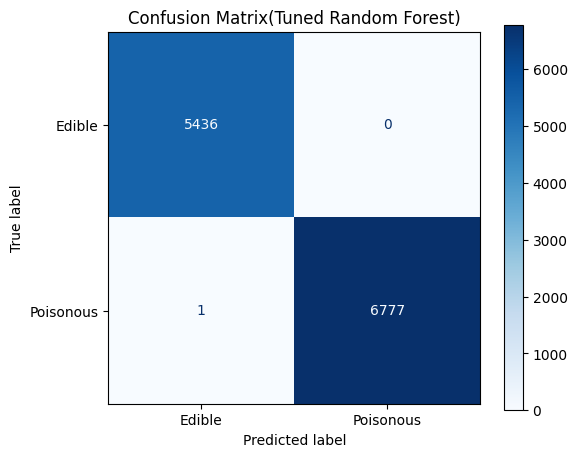

In [ ]:
# Graph 8: Confusion Matrix (Tuned Random Forest)
print("\nConfusion Matrix(Tuned Random Forest)...")

fig, ax = plt.subplots(figsize=(6, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, ax=ax, cmap='Blues', display_labels=['Edible', 'Poisonous'])
ax.set_title("Confusion Matrix(Tuned Random Forest)")
plt.savefig('confusion_matrix_rf_tuned_final.png')
print("Image Saved to Disk")


ROC Curve(Tuned Random Forest)...
Image Saved to Disk


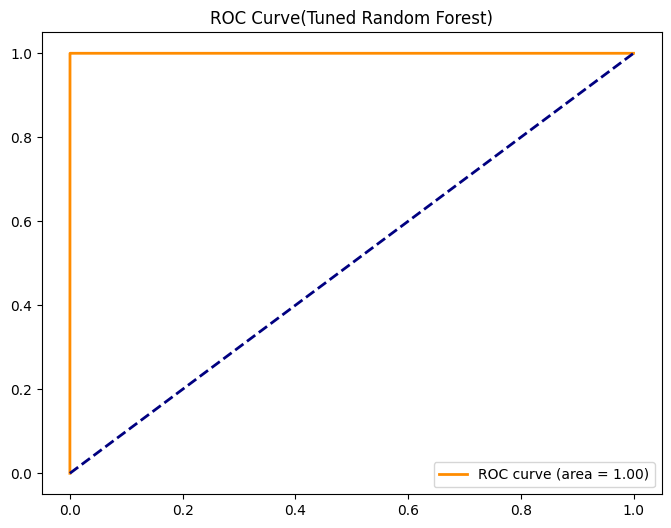

In [ ]:
# Graph 9: ROC Curve (Tuned Random Forest)
print("\nROC Curve(Tuned Random Forest)...")

fpr, tpr, thresholds = roc_curve(y_test, y_proba_rf)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc="lower right")
plt.title('ROC Curve(Tuned Random Forest)')
plt.savefig('roc_curve_rf_tuned_final.png')
print("Image Saved to Disk")


Feature Importance(Tuned Random Forest)...
Image Saved to Disk


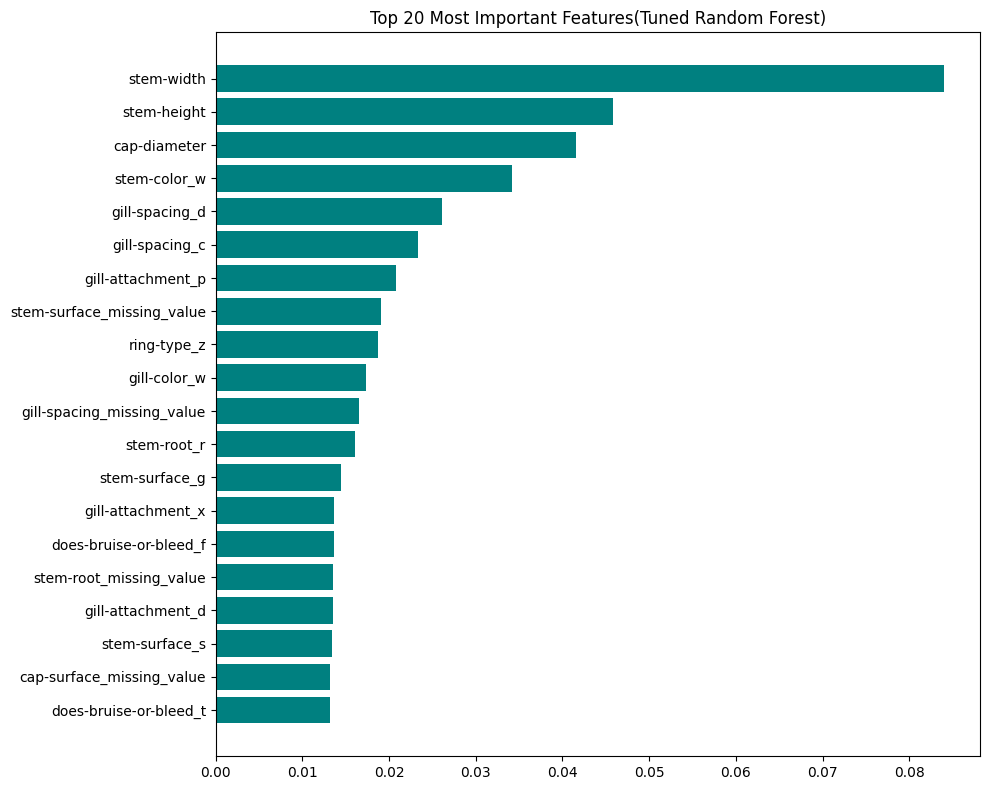

In [ ]:
# Graph 10: Feature Importance (Tuned Random Forest)
print("\nFeature Importance(Tuned Random Forest)...")

importances = best_model.named_steps['classifier'].feature_importances_
ohe = best_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
cat_feature_names = ohe.get_feature_names_out(categorical_cols)
all_feature_names = np.r_[numeric_cols, cat_feature_names]
indices = np.argsort(importances)[-20:]

plt.figure(figsize=(10, 8))
plt.barh(range(len(indices)), importances[indices], color='teal', align="center")
plt.yticks(range(len(indices)), [all_feature_names[i] for i in indices])
plt.title("Top 20 Most Important Features(Tuned Random Forest)")
plt.tight_layout()
plt.savefig('feature_importance_rf_tuned_final.png')
print("Image Saved to Disk")

In [ ]:
# Error Analysis (Report evidence) - kept for reproducibility


import numpy as np

err_df = X_test.copy()
err_df["y_true"] = y_test.values
err_df["y_pred"] = y_pred_rf
err_df["proba_poisonous"] = y_proba_rf

err_df["error_type"] = "Correct"
err_df.loc[(err_df["y_true"]==1) & (err_df["y_pred"]==0), "error_type"] = "FN (poisonous->edible)"
err_df.loc[(err_df["y_true"]==0) & (err_df["y_pred"]==1), "error_type"] = "FP (edible->poisonous)"

print("Error type counts:")
print(err_df["error_type"].value_counts(), "\n")

fn_df = err_df[err_df["error_type"] == "FN (poisonous->edible)"].copy()
fp_df = err_df[err_df["error_type"] == "FP (edible->poisonous)"].copy()

print(f"Total FN (dangerous): {len(fn_df)}")
print(f"Total FP: {len(fp_df)}")

# FN içinde en sık görülen değerler 
for col in categorical_cols:
    top_vals = fn_df[col].value_counts(dropna=False).head(3)
    if len(top_vals) > 0:
        print(f"\n[col={col}] Top FN values:")
        print(top_vals)


Error type counts:
error_type
Correct                   12213
FN (poisonous->edible)        1
Name: count, dtype: int64 

Total FN (dangerous): 1
Total FP: 0

[col=cap-shape] Top FN values:
cap-shape
x    1
Name: count, dtype: int64

[col=cap-surface] Top FN values:
cap-surface
d    1
Name: count, dtype: int64

[col=cap-color] Top FN values:
cap-color
n    1
Name: count, dtype: int64

[col=does-bruise-or-bleed] Top FN values:
does-bruise-or-bleed
f    1
Name: count, dtype: int64

[col=gill-attachment] Top FN values:
gill-attachment
p    1
Name: count, dtype: int64

[col=gill-spacing] Top FN values:
gill-spacing
NaN    1
Name: count, dtype: int64

[col=gill-color] Top FN values:
gill-color
y    1
Name: count, dtype: int64

[col=stem-root] Top FN values:
stem-root
NaN    1
Name: count, dtype: int64

[col=stem-surface] Top FN values:
stem-surface
NaN    1
Name: count, dtype: int64

[col=stem-color] Top FN values:
stem-color
n    1
Name: count, dtype: int64

[col=veil-type] Top FN values:



MODEL PERFORMANCE COMPARASION
                  Model  Accuracy  F1-Score  Precision  Recall
       Baseline (Dummy)    0.5549    0.7138     0.5549  1.0000
    Logistic Regression    0.8683    0.8787     0.8982  0.8601
Random Forest (Default)    1.0000    1.0000     1.0000  1.0000
  Random Forest (Tuned)    0.9999    0.9999     1.0000  0.9999
------------------------------------------------------------
Result saved as 'model_comparison_table.png'


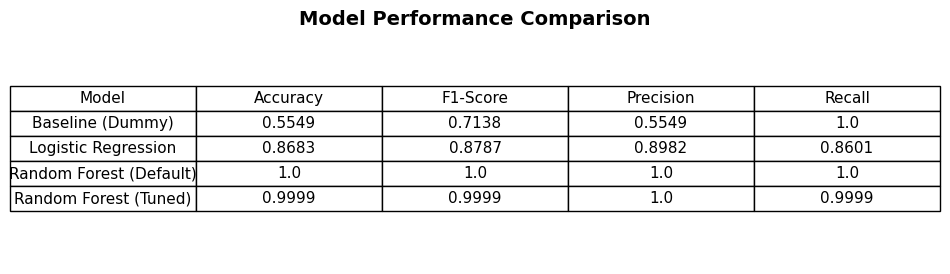

In [ ]:
# Result Table
print("\n" + "="*60)
print("MODEL PERFORMANCE COMPARASION")
print("="*60)

# Preparing data
results_data = {
    "Model": ["Baseline (Dummy)", "Logistic Regression", "Random Forest (Default)", "Random Forest (Tuned)"],
    "Accuracy": [dummy_acc, lr_acc, rf_def_acc, rf_acc],
    "F1-Score": [dummy_f1, lr_f1, rf_def_f1, rf_f1],
    "Precision": [dummy_prec, lr_prec, rf_def_prec,rf_prec],
    "Recall": [dummy_rec, lr_rec, rf_def_rec, rf_rec]
}

df_results = pd.DataFrame(results_data)

print(df_results.to_string(index=False, float_format="%.4f"))
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_results.round(4).values, 
                 colLabels=df_results.columns, 
                 cellLoc='center', 
                 loc='center')

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.5)

plt.title("Model Performance Comparison", fontsize=14, weight='bold')
plt.savefig('model_comparison_table.png', bbox_inches='tight', dpi=300)

print("-" * 60)
print("Result saved as 'model_comparison_table.png'")
